In [72]:
!qbraid jobs enable default

Successfully enabled qBraid Quantum Jobs in the default environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys/tokens are necessary. 

To disable, run: `qbraid jobs disable default`


In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qbraid import device_wrapper, job_wrapper, get_jobs
from collections import Counter

In [10]:
#Reminder: cirq.CNOT(control,target)
#Reference:
#https://quantumcomputing.stackexchange.com/questions/9623/constructing-a-circuit-for-c1u-for-rotation-operators-with-two-single-qubit

def cRy(theta,target,control):
    yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=-theta/2).on(target)
    yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=theta/2).on(target)

def xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[1],env[0])
    yield from cRy(2*np.arcsin(np.sqrt(p)),sys[1],env[0])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[0])
    yield cirq.CNOT(sys[1],env[0])

def zz_xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield from cRy(2*np.arcsin(np.sqrt(p)),sys[0],env[0])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[0]).controlled_by(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[1])
    yield cirq.CNOT(sys[1],env[1])
    yield from cRy(2*np.arcsin(np.sqrt(p)),sys[1],env[1])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[1])
    yield cirq.CNOT(sys[1],env[1])

In [46]:
env = [cirq.LineQubit(0),cirq.LineQubit(3)]
sys = [cirq.LineQubit(1),cirq.LineQubit(2)]
probs = np.linspace(0,1,num=5)
repcnt = 1024

Mappings:

$\vert \phi+ \rangle = \vert 00 \rangle$

$\vert \psi+ \rangle = \vert 01 \rangle$

$\vert \phi- \rangle = \vert 10 \rangle$

$\vert \psi- \rangle = \vert 11 \rangle$

In [21]:
def calc_pump_sim(pump,sys,env,p,repcnt):
    
    simulator = cirq.Simulator()
    final_hist = Counter()
    
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&2) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        circuit.append(cirq.measure(sys, key = 'answer'))
        
        result = simulator.run(circuit,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        final_hist += histogram

    for x in final_hist:
        final_hist[x]/=(4*repcnt)

    return final_hist

In [5]:
device_id = "aws_oqc_lucy"
device = device_wrapper(device_id)
print(device.metadata())

{'id': 'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', 'name': 'Lucy', 'provider': 'Oxford', 'vendor': 'AWS', 'numQubits': 8, 'deviceType': 'QPU', 'status': 'ONLINE', 'queueDepth': 0}


In [33]:
for j in range(2**2):
    ctest = cirq.Circuit()
    if (j&1) == 1:
        ctest.append(cirq.X.on(sys[0]))
    if (j&2) == 2:
        ctest.append(cirq.X.on(sys[1]))
    ctest.append(xx_pump(sys,env,0.2))
    ctest_transpiled = device.transpile(ctest)
    ctest_transpiled.probability(target=[1,2])
    print(ctest_transpiled)

T  : |0|1|2|3|    4    |5|   6    |7|Result Types|
                                                  
q0 : -X---X-C-----------C----------X--------------
          | |           |          |              
q1 : -X---|-|-----------|----------|-Probability--
      |   | |           |          | |            
q2 : -C-H-C-X-Ry(-0.46)-X-Ry(0.46)-C-Probability--

T  : |0|1|2|3|    4    |5|   6    |7|Result Types|
T  : |0|1|2|3|4|    5    |6|   7    |8|Result Types|
                                                    
q0 : -X-----X-C-----------C----------X--------------
            | |           |          |              
q1 : -X-X---|-|-----------|----------|-Probability--
        |   | |           |          | |            
q2 : ---C-H-C-X-Ry(-0.46)-X-Ry(0.46)-C-Probability--

T  : |0|1|2|3|4|    5    |6|   7    |8|Result Types|
T  : |0|1|2|3|4|    5    |6|   7    |8|Result Types|
                                                    
q0 : -X-----X-C-----------C----------X--------------
       

In [26]:
def oqc_create_jobs(pump,sys,env,p,repcnt):
    job_id_list = []
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&2) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        transpiled_circuit = device.transpile(circuit)
        job = device.run(transpiled_circuit,shots=repcnt)
        job_id_list.append(job.id)
    return job_id_list

<h2>ZZ XX pump:</h2>

In [27]:
zz_xx_job_ids = []

In [34]:
print('Job ids for probabilities',*probs)
for p in probs:
    job_ids = oqc_create_jobs(zz_xx_pump,sys,env,p,repcnt)
    zz_xx_job_ids.append(job_ids)

Job ids for probabilities 0.0 0.25 0.5 0.75 1.0


In [35]:
print(zz_xx_job_ids)

[['aws_oqc_lucy-contactmainakroy-qjob-8pvierejhulxeotgbkoe', 'aws_oqc_lucy-contactmainakroy-qjob-p64s5bscfq1kymy2j0bu', 'aws_oqc_lucy-contactmainakroy-qjob-w7xr6a1saoru9ssxmxwu', 'aws_oqc_lucy-contactmainakroy-qjob-zy6cmudnxz00zo4s1nox'], ['aws_oqc_lucy-contactmainakroy-qjob-ioha026d116fl5m3hd71', 'aws_oqc_lucy-contactmainakroy-qjob-p3y7b56fwzvyy8gho75y', 'aws_oqc_lucy-contactmainakroy-qjob-mmpurju8bgnefy57mwt0', 'aws_oqc_lucy-contactmainakroy-qjob-w3qehoougsc2z2na43z2'], ['aws_oqc_lucy-contactmainakroy-qjob-yrxmwlm6etkop71mc9we', 'aws_oqc_lucy-contactmainakroy-qjob-vez4qetwfdkoys0bqrrr', 'aws_oqc_lucy-contactmainakroy-qjob-aboa9erjsbq7g4smehqs', 'aws_oqc_lucy-contactmainakroy-qjob-183198sta74de1fpik6m'], ['aws_oqc_lucy-contactmainakroy-qjob-n5uvul6v4e7x6akmgno3', 'aws_oqc_lucy-contactmainakroy-qjob-ilxlwlei7rm4u4brp4bq', 'aws_oqc_lucy-contactmainakroy-qjob-7jblwpzqoknz46k5m0kt', 'aws_oqc_lucy-contactmainakroy-qjob-pwxlw4n5rqs8b6cs4w12'], ['aws_oqc_lucy-contactmainakroy-qjob-xofqx7iml3

In [48]:
result = job_wrapper(zz_xx_job_ids[3][0]).result()._result

In [52]:
#[probs][mask]
pops_real = [[],[],[],[]]
for job_id_list in zz_xx_job_ids:
    results = [job_wrapper(job_id).result() for job_id in job_id_list]
    probs_f = [0.0,0.0,0.0,0.0]
    for result in results:
        prob = result._result.measurement_probabilities
        for key,val in prob.items():
            probs_f[int(key[1:3],2)] += val
    for i in range(4):
        pops_real[i].append(probs_f[i])

<h2>Comparison with theory:</h2>

In [58]:
def calc_plot(hists):
    pops = [[],[],[],[]]
    for counts in hists:
        for i in range(4):
            pops[i].append(counts[i])
    return pops

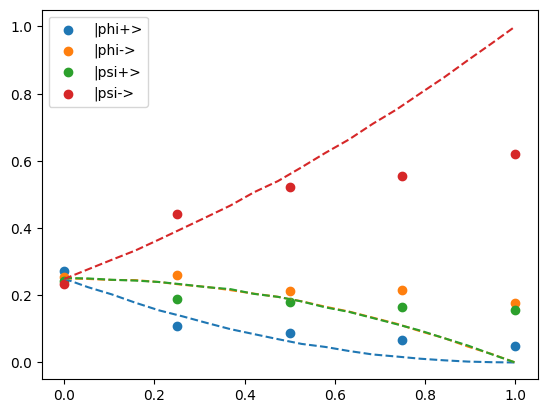

In [65]:
plt.scatter(probs,np.array(pops_real[0])/4,label='|phi+>')
plt.scatter(probs,np.array(pops_real[1])/4,label='|phi->')
plt.scatter(probs,np.array(pops_real[2])/4,label='|psi+>')
plt.scatter(probs,np.array(pops_real[3])/4,label='|psi->')

sim_probs = np.linspace(0,1,num=20)
hists = [calc_pump_sim(zz_xx_pump,sys,env,p,20000) for p in sim_probs]
pops = calc_plot(hists)
plt.plot(sim_probs,pops[0],linestyle='--')
plt.plot(sim_probs,pops[1],linestyle='--')
plt.plot(sim_probs,pops[2],linestyle='--')
plt.plot(sim_probs,pops[3],linestyle='--')

plt.legend()
plt.show()